# A2.2 Multilayered Neural Network

* 2.2: *Added example output in Section 1.1.*
* 2.1: *Added A2grader.tar and details on how to rename the functions for the use of the asymmetric sigmoid activation function.*

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def add_ones(X):
    return np.insert(X, 0, 1, axis=1)

def rmse(Y, T):
    error = T - Y
    return np.sqrt(np.mean(error ** 2))

def calc_standardize_parameters(X, T):
    Xmeans = X.mean(axis=0)
    Xstds = X.std(axis=0)
    Tmeans = T.mean(axis=0)
    Tstds = T.std(axis=0)
    return {'Xmeans': Xmeans, 'Xstds': Xstds,
            'Tmeans': Tmeans, 'Tstds': Tstds}

def standardize_X(X, stand_parms):
    return (X - stand_parms['Xmeans']) / stand_parms['Xstds']


def unstandardize_X(Xst, stand_parms):
    return Xst * stand_parms['Xstds'] + stand_parms['Xmeans']


def standardize_T(T, stand_parms):
    return (T - stand_parms['Tmeans']) / stand_parms['Tstds']


def unstandardize_T(Tst, stand_parms):
    return Tst * stand_parms['Tstds'] + stand_parms['Tmeans']

Here is a test of the functions.  We fit a neural network to simple one-dimensional data.

In [28]:
n_samples = 30

Xtrain = np.linspace(0., 20.0, n_samples).reshape((n_samples, 1))
Ttrain = 0.2 + 0.05 * (Xtrain) + 0.4 * np.sin(Xtrain / 2) + 0.2 * np.random.normal(size=(n_samples, 1))

Xtest = Xtrain + 0.1 * np.random.normal(size=(n_samples, 1))
Ttest = 0.2 + 0.05 * (Xtest) + 0.4 * np.sin(Xtest / 2) + 0.2 * np.random.normal(size=(n_samples, 1))

## Required Part One

The changes you must implement are specified here.  We recommend that you copy the above code cells and paste them below, then edit them appropriately.

You will implement a set of functions for training and testing a multilayered neural network to predict continuous-valued target values.  This assignment provides an implementation of the functions for a neural network with one hidden layer.  You must modify the functions to allow any number of hidden layers, each with any number of units.

The required functions are:

* `make_weights(n_inputs, n_hiddens_list, n_outputs):` Given integers `n_inputs`, list of `n_hiddens`, one integer per hidden layer, and `n_outputs`, create and return list of weight matrices, one for each layer.
* `forward(Xst, Ws)`: Given standardized input matrix `X` and list of weight matrices `Ws`, calculate the output of all layers and return a list of the outputs of each layer.
* `backward(Xst, Tst, Ws)`: Given standardized input matrix `X`, standardized target matrix `T`, and list of weight matrices `Ws`, calculate the gradient of the mean squared error with respect to the weights in each layer, returning a tuple or list of all gradient matrices.
* `train_sgd(X, T, Ws, learning_rate, n_epochs):` Given input and target matrices `X` and `T`, liist of all weight matrices `Ws`, a learning_rate and the number of epochs to train, update the weights for `n_epochs` iterations using the gradient of the mean squared over the whole data set in `X` and `T`  and return the list of resulting new weight matrices, the standardization parameters, and the list of RMSE training errors, one per epoch.
* `use(X, Ws, stand_parms):` Calculate outputs of all layers after standardizing input `X`. Return list of outputs of each hidden layer, and unstandardized output of output layer.

In [9]:
X = np.arange(5).reshape(-1, 1)
T = (X - 2) ** 3

stand_parms = calc_standardize_parameters(X, T)

In [10]:
def make_weights(n_inputs, n_hiddens, n_outputs):
    #First layer (input)
    layer_list = [np.random.uniform(-1, 1, size=(1 + n_inputs, n_hiddens[0])) / np.sqrt(n_inputs + 1)]
    
    #All hidden layers after first
    for i in range(1, len(n_hiddens)):
        hidden_layer = np.random.uniform(-1, 1, size=(1 + n_hiddens[i - 1], n_hiddens[i])) / np.sqrt(n_hiddens[i - 1] + 1)
        layer_list.append(hidden_layer)
        
    #Last layer (output)    
    output_layer = np.random.uniform(-1, 1, size=(1 + n_hiddens[-1], n_outputs)) / np.sqrt(n_hiddens[-1] + 1)
    
    layer_list.append(output_layer)
    return layer_list

In [11]:
np.random.seed(42)  # Set the random number generator seed so same weight values are generated each time.
n_inputs = 1
n_hiddens_list = [2, 3]
n_outputs = 1
Ws = make_weights(n_inputs, n_hiddens_list, n_outputs)
Ws

[array([[-0.17742707,  0.63740628],
        [ 0.32808898,  0.13952417]]),
 array([[-0.39719546, -0.39722331, -0.51028109],
        [ 0.42282379,  0.11675756,  0.24026152],
        [-0.55358134,  0.54260516,  0.3838717 ]]),
 array([[-0.28766089],
        [-0.31817503],
        [-0.31659549],
        [-0.19575776]])]

In [12]:
def forward(Xst, Ws):
    layers_final = []
    
    #Input layer 
    Z_input = np.tanh(add_ones(Xst) @ Ws[0])
    layers_final.append(Z_input)
    
    #All but the output layer (no activation function)
    for i in range(1, len(Ws) - 1):
        Z = np.tanh(add_ones(layers_final[i - 1]) @ Ws[i])
        layers_final.append(Z)
    
    #Output layer
    Yst = add_ones(layers_final[-1]) @ Ws[-1]
    layers_final.append(Yst)
    
    return layers_final

In [13]:
Xst = standardize_X(X, stand_parms)

forward(Xst, Ws)

[array([[-0.56586221,  0.41371847],
        [-0.38798095,  0.49203951],
        [-0.17558839,  0.56313093],
        [ 0.05451278,  0.6267617 ],
        [ 0.27896633,  0.68300402]]),
 array([[-0.69907152, -0.23436786, -0.45216727],
        [-0.68241869, -0.17375875, -0.39238667],
        [-0.65452655, -0.11169878, -0.32416858],
        [-0.61759623, -0.05073081, -0.25110112],
        [-0.57659057,  0.00594955, -0.17911703]]),
 array([[ 0.09748127],
        [ 0.06129167],
        [ 0.01941496],
        [-0.02594105],
        [-0.07102422]])]

In [14]:
def backward(Xst, Tst, Wst):
    n_samples = Xst.shape[0]
    n_outputs = Tst.shape[1]
    gradient_list = []
    
    # Init forward values
    outputs = forward(Xst, Wst)
    
    # Init Delta
    delta = -(Tst - outputs[-1]) /  (n_samples * n_outputs)
    
    # Back-propagate the delta value from the output layer, through the output layer weights,
    # to the hidden units.  Multiply the result by the derivative of the hidden units'
    # activation function, tanh
    Wst.reverse()
    outputs.reverse()
    for i in range(len(Wst)):
        # Output Layer
        if i == 0:
            gradient_W = add_ones(outputs[i + 1]).T @ delta
            gradient_list.append(gradient_W)
        # Hidden Layer(s)
        elif i != len(Wst) - 1:  
            delta = (delta @ Wst[i - 1][1:, :].T) * (1 - outputs[i] ** 2)
            gradient_V = add_ones(outputs[i + 1]).T @ delta
            gradient_list.insert(0,gradient_V)
        # Input Layer
        else:
            delta = (delta @ Wst[i - 1][1:, :].T) * (1 - outputs[i] ** 2)
            gradient_V = add_ones(Xst).T @ delta
            gradient_list.insert(0,gradient_V)
    
    Wst.reverse()
    return gradient_list

In [15]:
Tst = standardize_T(T, stand_parms)
backward(Xst, Tst, Ws)

[array([[ 0.02036822, -0.01636089],
        [ 0.12862245,  0.0892945 ]]),
 array([[0.01472725, 0.00112042, 0.00918263],
        [0.05411053, 0.09250499, 0.05057852],
        [0.02592358, 0.02999365, 0.02150022]]),
 array([[ 0.01624453],
        [-0.05411685],
        [-0.08718807],
        [-0.10225819]])]

In [16]:
def train_sgd(X, T, Ws, learning_rate, n_epochs):
    # Store standardization parameters in dictionary stand_parms.
    stand_parms = calc_standardize_parameters(X, T)
    # Standardize X and T.
    Xst = standardize_X(X, stand_parms)
    Tst = standardize_T(T, stand_parms)

    error_trace = []

    # Update weights for n_epochs passes through the training data
    for epoch in range(n_epochs):

        # Calculate the gradients of the mean squared error with respect to each weight matrix.
        gradient_list = backward(Xst, Tst, Ws)
        
        # Update the values in each weight matrix using SGD.
        for i in range(len(Ws)):
            Ws[i] -= learning_rate * gradient_list[i]

        # Calculate the outputs of all layers given the current weight values.
        Yst = forward(Xst, Ws)
        Y = unstandardize_T(Yst[-1], stand_parms)
        error_trace.append(rmse(Y, T))

    return Ws, stand_parms, error_trace

In [17]:
def use(X, Ws, stand_parms):
    # Standardize inputs X
    Xst = standardize_X(X, stand_parms)
    # Calculate outputs of each layer.
    Yst = forward(Xst, Ws)
    # Unstandardize output of output layer
    Yst[-1] = unstandardize_T(Yst[-1], stand_parms)
    return Yst

In [18]:
use(X, Ws, stand_parms)

[array([[-0.56586221,  0.41371847],
        [-0.38798095,  0.49203951],
        [-0.17558839,  0.56313093],
        [ 0.05451278,  0.6267617 ],
        [ 0.27896633,  0.68300402]]),
 array([[-0.69907152, -0.23436786, -0.45216727],
        [-0.68241869, -0.17375875, -0.39238667],
        [-0.65452655, -0.11169878, -0.32416858],
        [-0.61759623, -0.05073081, -0.25110112],
        [-0.57659057,  0.00594955, -0.17911703]]),
 array([[ 0.49705891],
        [ 0.31252744],
        [ 0.09899728],
        [-0.13227391],
        [-0.36215388]])]

Test your functions on the same one-dimensional data defined above as `Xtrain, Ttrain` and `Xtest, Ttest` shown above.  Try your code using two hidden layers of as many units in each layer as you wish.  Plot the results, including an additional plot to show the outputs of each of the two hidden layers.

In [29]:
# Train using given data (Xtrain, etc)
n_inputs = Xtrain.shape[1]
n_hiddens = [5,10]
n_outputs = Ttrain.shape[1]

n_epochs = 2000
learning_rate = 0.1

Ws = make_weights(n_inputs, n_hiddens, n_outputs)

Ws, stand_parms, error_trace = train_sgd(Xtrain, Ttrain, Ws, learning_rate, n_epochs)

Ytrain = use(Xtrain, Ws, stand_parms)
rmse_train = rmse(Ytrain[-1], Ttrain)
Ytest = use(Xtest, Ws, stand_parms)
rmse_test = rmse(Ytest[-1], Ttest)

print(f'RMSE: Train {rmse_train:.2f} Test {rmse_test:.2f}')

RMSE: Train 0.16 Test 0.22


Text(0, 0.5, 'Hidden Unit Outputs')

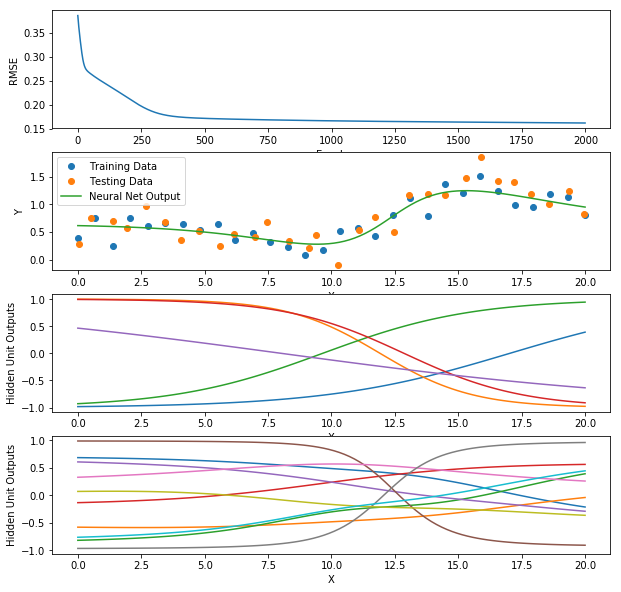

In [30]:
# Plot results from training with given data
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(error_trace)
plt.xlabel('Epoch')
plt.ylabel('RMSE')

plt.subplot(4, 1, 2)
plt.plot(Xtrain, Ttrain, 'o', label='Training Data')
plt.plot(Xtest, Ttest, 'o', label='Testing Data')
X_for_plot = np.linspace(0, 20, 100).reshape(-1, 1)
Y_train = use(X_for_plot, Ws, stand_parms)
plt.plot(X_for_plot, Y_train[-1], label='Neural Net Output')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(4, 1, 3)
plt.plot(X_for_plot, Y_train[0])
plt.xlabel('X')
plt.ylabel('Hidden Unit Outputs')

plt.subplot(4, 1, 4)
plt.plot(X_for_plot, Y_train[1])
plt.xlabel('X')
plt.ylabel('Hidden Unit Outputs')

Write a for loop to create and train neural nets containing one, two, three and four hidden layers each with 4 hidden units. Train each for 10,000 epochs and a learning rate of 0.1. Collect list of results with each result being a list containing the number of layers and the RMSE for training and testing data.

Print a pretty table of your results be creating a `pandas` DataFrame of the results list (of lists). Discuss the results.

In [38]:
# Iterate and create NN with 1..N layers

hidden_layers_list = [[4], [4,4], [4,4,4], [4,4,4,4]]
n_epochs = 10000
learning_rate = 0.1

results = []

for layer in hidden_layers_list:
    
    Ws = make_weights(n_inputs, layer, n_outputs)

    Ws, stand_parms, error_trace = train_sgd(Xtrain, Ttrain, Ws, learning_rate, n_epochs)

    Ytrain = use(Xtrain, Ws, stand_parms)
    rmse_train = rmse(Ytrain[-1], Ttrain)
    Ytest = use(Xtest, Ws, stand_parms)
    rmse_test = rmse(Ytest[-1], Ttest)
    
    results.append([len(layer), rmse_train, rmse_test])

    print(f'RMSE: Train {rmse_train:.2f} Test {rmse_test:.2f}')

results

RMSE: Train 0.15 Test 0.23
RMSE: Train 0.14 Test 0.23
RMSE: Train 0.14 Test 0.23
RMSE: Train 0.14 Test 0.23


[[1, 0.1483634172009399, 0.22824331830220268],
 [2, 0.14312604306417998, 0.22659858476432002],
 [3, 0.13940806279634618, 0.23023087230075118],
 [4, 0.14054177568907336, 0.22795803322572078]]

In [32]:
import pandas
df = pandas.DataFrame(results, columns=('Layers', 'RMSE Train', 'RMSE Test'))
df

,Layers,RMSE Train,RMSE Test
0,1,0.148205,0.227303
1,2,0.143760,0.226630
2,3,0.144032,0.230596
3,4,0.140263,0.227416


### Discussion: tanh

The table above shows the convergence of the **tanh** activation function over a period of 1 to 4, 4 neuron hidden layers each with 10000 training cycles (epochs). Theoretically, more hidden layers in a given network enables a closer fit to the given dataset as more and more subleties are accounted for by the additional layers.

In the case of the above experiment, there is no discernable increase in training or test accuracy as the number of hidden layers increases. The RMSE values remain almost constant over all layer variants. This is likely due to the fact that the network has _already_ converged upon a local minima for this data, and is simply osciallating about it.

## Required Part Two

Copy and paste here the following functions and rename them as shown.  These new versions will use the asymmetric sigmoid activation function instead of the symmetric one that used `tanh`.  Repeat the above experiments with the one-dimensional data.

* `forward` becomes `forward_asig`
* `backward` becomes `backward_asig`
* `train_sgd` becomes `train_sgd_asig`
* `use` becomes `use_asig`

In [ ]:
def asig(X):
    return 1/(1 + np.exp(-X))

def forward_asig(Xst, Ws):
    layers_final = []
    
    #Input layer 
    Z_input = asig(add_ones(Xst) @ Ws[0])
    layers_final.append(Z_input)
    
    #All but the output layer (no activation function)
    for i in range(1, len(Ws) - 1):
        Z = asig(add_ones(layers_final[i - 1]) @ Ws[i])
        layers_final.append(Z)
    
    #Output layer
    Yst = add_ones(layers_final[-1]) @ Ws[-1]
    layers_final.append(Yst)
    
    return layers_final

def backward_asig(Xst, Tst, Wst):
    n_samples = Xst.shape[0]
    n_outputs = Tst.shape[1]
    gradient_list = []
    
    # Init forward values
    outputs = forward_asig(Xst, Wst)
    
    # Init Delta
    delta = -(Tst - outputs[-1]) /  (n_samples * n_outputs)
    
    # Back-propagate the delta value from the output layer, through the output layer weights,
    # to the hidden units.  Multiply the result by the derivative of the hidden units'
    # activation function, tanh
    Wst.reverse()
    outputs.reverse()
    for i in range(len(Wst)):
        # Output Layer
        if i == 0:
            gradient_W = add_ones(outputs[i + 1]).T @ delta
            gradient_list.append(gradient_W)
        # Hidden Layer(s)
        elif i != len(Wst) - 1:  
            delta = (delta @ Wst[i - 1][1:, :].T) * ((outputs[i]) * (1 - (outputs[i])))
            gradient_V = add_ones(outputs[i + 1]).T @ delta
            gradient_list.insert(0,gradient_V)
        # Input Layer
        else:
            delta = (delta @ Wst[i - 1][1:, :].T) * ((outputs[i]) * (1 - (outputs[i])))
            gradient_V = add_ones(Xst).T @ delta
            gradient_list.insert(0,gradient_V)
    
    Wst.reverse()
    return gradient_list

def train_sgd_asig(X, T, Ws, learning_rate, n_epochs):
    # Store standardization parameters in dictionary stand_parms.
    stand_parms = calc_standardize_parameters(X, T)
    # Standardize X and T.
    Xst = standardize_X(X, stand_parms)
    Tst = standardize_T(T, stand_parms)

    error_trace = []

    # Update weights for n_epochs passes through the training data
    for epoch in range(n_epochs):

        # Calculate the gradients of the mean squared error with respect to each weight matrix.
        gradient_list = backward_asig(Xst, Tst, Ws)
        
        # Update the values in each weight matrix using SGD.
        for i in range(len(Ws)):
            Ws[i] -= learning_rate * gradient_list[i]

        # Calculate the outputs of all layers given the current weight values.
        Yst = forward_asig(Xst, Ws)
        Y = unstandardize_T(Yst[-1], stand_parms)
        error_trace.append(rmse(Y, T))

    return Ws, stand_parms, error_trace

def use_asig(X, Ws, stand_parms):
    # Standardize inputs X
    Xst = standardize_X(X, stand_parms)
    # Calculate outputs of each layer.
    Yst = forward_asig(Xst, Ws)
    # Unstandardize output of output layer
    Yst[-1] = unstandardize_T(Yst[-1], stand_parms)
    return Yst

In [33]:
# Train using given data (Xtrain, etc)
n_inputs = Xtrain.shape[1]
n_hiddens = [5,10]
n_outputs = Ttrain.shape[1]

n_epochs = 2000
learning_rate = 0.1

Ws = make_weights(n_inputs, n_hiddens, n_outputs)

Ws, stand_parms, error_trace = train_sgd_asig(Xtrain, Ttrain, Ws, learning_rate, n_epochs)

Ytrain = use_asig(Xtrain, Ws, stand_parms)
rmse_train = rmse(Ytrain[-1], Ttrain)
Ytest = use_asig(Xtest, Ws, stand_parms)
rmse_test = rmse(Ytest[-1], Ttest)

print(f'RMSE: Train {rmse_train:.2f} Test {rmse_test:.2f}')

RMSE: Train 0.22 Test 0.29


Text(0, 0.5, 'Hidden Unit Outputs')

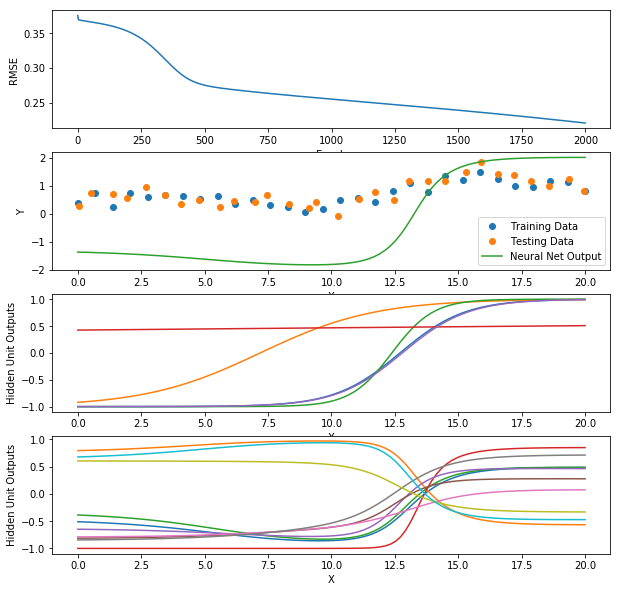

In [34]:
# Plot results from training with given data
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(error_trace)
plt.xlabel('Epoch')
plt.ylabel('RMSE')

plt.subplot(4, 1, 2)
plt.plot(Xtrain, Ttrain, 'o', label='Training Data')
plt.plot(Xtest, Ttest, 'o', label='Testing Data')
X_for_plot = np.linspace(0, 20, 100).reshape(-1, 1)
Y_train = use(X_for_plot, Ws, stand_parms)
plt.plot(X_for_plot, Y_train[-1], label='Neural Net Output')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(4, 1, 3)
plt.plot(X_for_plot, Y_train[0])
plt.xlabel('X')
plt.ylabel('Hidden Unit Outputs')

plt.subplot(4, 1, 4)
plt.plot(X_for_plot, Y_train[1])
plt.xlabel('X')
plt.ylabel('Hidden Unit Outputs')

In [35]:
# Iterate and create NN with 1..N layers

hidden_layers_list = [[4], [4,4], [4,4,4], [4,4,4,4]]
n_epochs = 10000
learning_rate = 0.1

results = []

for layer in hidden_layers_list:
    
    Ws = make_weights(n_inputs, layer, n_outputs)

    Ws, stand_parms, error_trace = train_sgd_asig(Xtrain, Ttrain, Ws, learning_rate, n_epochs)

    Ytrain = use_asig(Xtrain, Ws, stand_parms)
    rmse_train = rmse(Ytrain[-1], Ttrain)
    Ytest = use_asig(Xtest, Ws, stand_parms)
    rmse_test = rmse(Ytest[-1], Ttest)
    
    results.append([len(layer), rmse_train, rmse_test])

    print(f'RMSE: Train {rmse_train:.2f} Test {rmse_test:.2f}')

results

RMSE: Train 0.16 Test 0.22
RMSE: Train 0.16 Test 0.23
RMSE: Train 0.16 Test 0.22
RMSE: Train 0.36 Test 0.45


[[1, 0.16302095291522495, 0.22421985677887513],
 [2, 0.16269098858867417, 0.2315647013072359],
 [3, 0.163816650734786, 0.2240530578429693],
 [4, 0.36301455782484227, 0.44637600317766335]]

In [36]:
import pandas
df = pandas.DataFrame(results, columns=('Layers', 'RMSE Train', 'RMSE Test'))
df

,Layers,RMSE Train,RMSE Test
0,1,0.163021,0.224220
1,2,0.162691,0.231565
2,3,0.163817,0.224053
3,4,0.363015,0.446376


### Discussion: sigmoid

The experiment above was repeated with the same parameters as the previous (1 to 4 hidden layers each with 4 hidden units over 10000 training cycles). Comparing the results of the **sigmoid** and the **tanh**, they have very simiar RMSE values for the first three iterations, with the **tanh** function performing just a hair better on average. 

It would then be safe to assume that both activation functions managed to find the same local minimia among the input data for the first three iterations. However, when the number of hidden layers using the **sigmoid** function was 4, the RMSE increased to almost double the value from the previous iteration on both the training and test data. 

Generally the danger of adding an excessive amount of layers is _overfitting_ the training data, and then underperforming on the test data. In this case, we see poor performance on both training and test data, so overfitting is likely not the culprit. I would wager that the inital values created with the forward passes and 4 hidden layers are _further_ from the local minima than the first three iterations.

In [39]:
%run -i A2grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Ridgeway-A2.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

## Testing ####################################################################

    X = np.arange(4).reshape(-1, 1) + 5
    T = np.array([1, 2, -3, -4]).reshape((-1, 1))
    Ws = make_weights(1, [3, 4], 1)
    for W in Ws:
        W[:] = np.linspace(-1, 1, W.size).reshape(W.shape)

    stand_parms = {'Xmeans': np.array([[0]]), 'Xstds': np.array([[1]]),
                   'Tmeans': np.array([[0]]), 'Tstds': np.array([[1]])}

    def print_layers(what, lst):
        print(f'{what}:')
        for (i, element) in enumerate(lst):
            print(f' Layer {i}:')
            print(f' {element}')

    print('X is')
    print(X)
    print_layers('Ws', Ws)
    print('stand_parms is')
    print(stand_parms)
    Ys = use(X, Ws, stand_parms)

X is
 [[5]
 [6]